In [1]:
from mpi4py import MPI
from petsc4py.PETSc import ScalarType #type: ignore
import numpy as np
import ufl
from dolfinx import fem, io, mesh, plot, cpp
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner
from scipy.interpolate import interp2d

In [2]:
# Load heat source values
heat = np.load("/home/shengbiaolu/snap/dolfinx-main/python/demo/Params/sample_f_32.npy")
heat.shape

(100, 32, 32)

In [3]:
# Load thermal conductivity
thermal_conductivity = np.load("/home/shengbiaolu/snap/dolfinx-main/python/demo/Params/sample_theta_32.npy")
thermal_conductivity.shape

(100, 32, 32)

In [4]:
x = np.linspace(-1,1,32)
y = np.linspace(-1,1,32)
x, y = np.meshgrid(x,y)

heat_interp = interp2d(x, y, heat[0])
conductivity_interp = interp2d(x, y, thermal_conductivity[0])

heat_f = lambda x: heat_interp(x[0], x[1])[0]
conductivity_theta = lambda x: conductivity_interp(x[0], x[1])[0]

In [5]:
# Create a Mesh and the element is the triangle
msh = mesh.create_rectangle(
    comm = MPI.COMM_WORLD,
    points = ((-1.0, -1.0),(1.0, 1.0)),
    n=(48, 48),
    cell_type=mesh.CellType.quadrilateral
)
V = fem.functionspace(msh, ("Lagrange", 1))

In [ ]:
# Define the Neumann Boundary Conditions

facets = mesh.locate_entities_boundary(
    msh,
    dim=(msh.topology.dim - 1),
    marker=lambda x: np.isclose(x[0], -1.0) | np.isclose(x[0], 1.0)
)

dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)

In [7]:
# Define the Dirichlet Boundary Conditions
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [8]:
# Define the variational problem 
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)

theta = fem.Function(V) # heat conductivity
theta.interpolate(conductivity_theta)

f = fem.Function(V) # Heat source
f.interpolate(heat_f)

g = ufl.sin(5 * x[0])
a = inner(grad(u), theta * grad(v)) * dx
L = inner(f, v) * dx + inner(g,theta * v) * ds

In [9]:
# Linear Problem
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type":"preonly", "pc_type":"lu"})
uh = problem.solve()

In [10]:
np.save("Heat.npy", uh.vector.array)

In [11]:
with io.XDMFFile(msh.comm, "out_steadyheat/heat.xdmf", "w") as file:
    file.write_mesh(msh)
    file.write_function(uh)

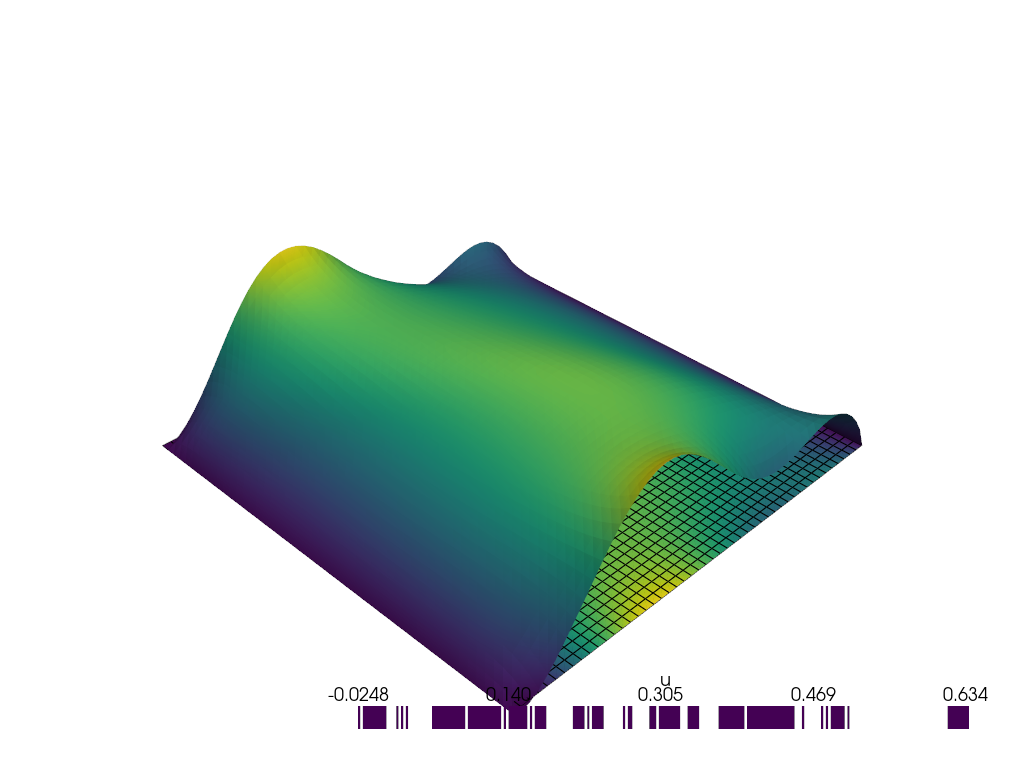

In [12]:
try:
    import pyvista

    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")